# Домашнее задание 2. StarGAN

### Загрузка данных
В данном задании вам предстоит работать с CelebA 64x64 и генерировать новые лица с заданными аттрибутами

In [1]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py'
open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);

In [2]:
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 

from torch import Tensor

Загрузим человекочитаемые названия доменов

In [3]:
with open('list_attr_celeba.txt', 'r') as f:
    attr_name = np.array(f.readline().split(' ')[:-1])
attr_name

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype='<U19')

In [4]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

Главная проблема мультидоменной генерации на селебе - наличие большого количества "бесполезных" классов, например 'Arched_Eyebrows', 'Attractive' 'Bags_Under_Eyes итд. Чтобы сделать задачу чуть проще, в этой домашке мы предлагаем вам взять 10 аттрибутов и учить im2im только на них

In [5]:
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        indices = [8, 9, 11, 15, 16, 20, 22, 28, 35, 39]
        image, target = super().__getitem__(idx)
        target = target['attributes'] == 1
        new_target = target[indices].float()
        if sum(new_target) == 0:
            return self.__getitem__(randint(0, len(self)-1))
        return image, new_target

In [6]:
attr_name = attr_name[[8, 9, 11, 15, 16, 20, 22, 28, 35, 39]]

In [7]:
crop = True
assert crop

dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=crop
)

img, attr = dataset[0]
img.shape

Downloading...
From: https://drive.google.com/uc?id=12agH1nWYcj7PAoErxQQgFdOAohgS9qE_
To: /content/data/celeba/img_align_celeba_crop.zip
100%|██████████| 3.55M/3.55M [00:00<00:00, 72.7MB/s]


torch.Size([3, 64, 64])

### Визуализация датасета

In [8]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

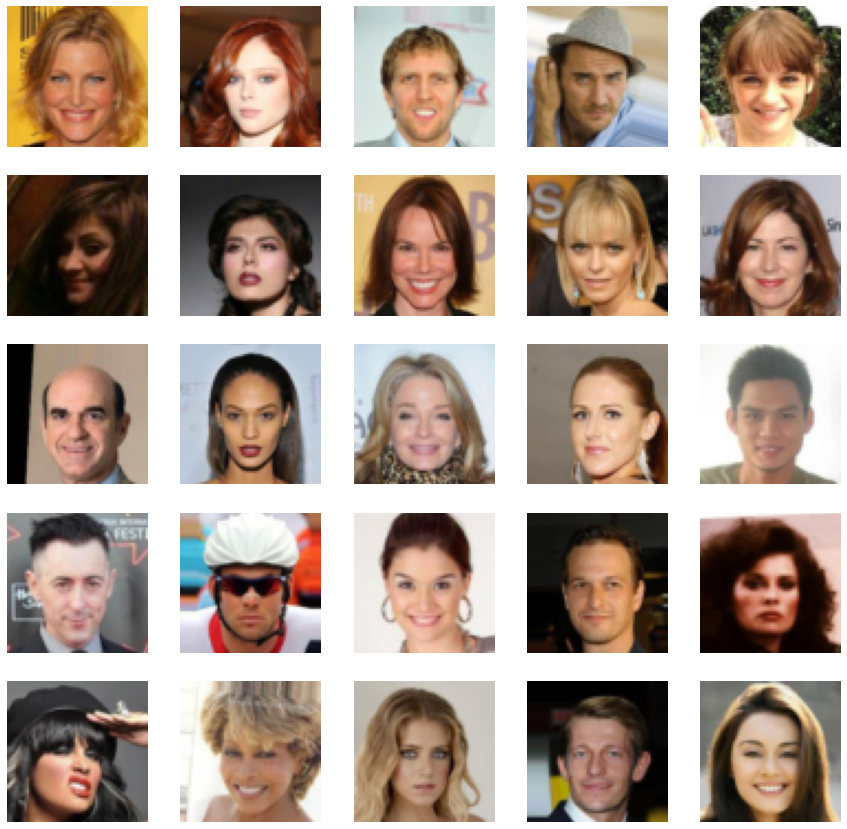

In [9]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img, attr = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1. Обучите low-res StarGanV1 на ограниченном подмножестве аттрибутов



В рамках данного задания предлагается реализовать и обучить [StarGAN v1](https://arxiv.org/pdf/1711.09020.pdf) для генерации лиц с заданными аттрибутами

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v1.png' width=600>

Вы можете добавлять любые дополнительные  параметры и использовать любые трюки для стабилизации/улучшения обучения на свое усмотрение. Ячейка для вспомогательных функций и классов:


In [10]:
### BEGIN SOLUTION
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm

from torch import Tensor

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(dim_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out)
        )

    def forward(self, x):
        return x + self.main(x)
### END SOLUTION

Определите класс генератора.

In [11]:
class Generator(nn.Module):
    def __init__(self, hidden_dim=64, target_dim=10, num_resblocks=3):
        """
        you can use any parameters here, for example ->
        hidden_dim: number of channels used in convs 
        """
        super().__init__()
        ### BEGIN SOLUTION

        layers = []
        layers.append(nn.Conv2d(3+target_dim, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = hidden_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(curr_dim*2))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(num_resblocks):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
            layers.append(nn.Conv2d(curr_dim, curr_dim//2, kernel_size=3, stride=1, padding=1, bias=False))
            
            layers.append(nn.BatchNorm2d(curr_dim//2))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        """
        x: original image 
        y: target domain
        """
        ### BEGIN SOLUTION

        y = y.view(y.size(0), y.size(1), 1, 1)
        y = y.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, y], dim=1)
        return self.main(x)

        ### END SOLUTION

Определите класс дискриминатора

In [12]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=64, target_dim=10, num_blocks=6,
                 img_size=64):
        super().__init__()
        ### BEGIN SOLUTION

        layers = []
        curr_dim = hidden_dim
        layers.append(nn.Conv2d(3, hidden_dim, kernel_size=4, stride=2, padding=1))
        for i in range(5):
            layers.append(nn.Conv2d(curr_dim, curr_dim * 2, kernel_size=4, stride=2, padding=1))
            curr_dim = curr_dim * 2
            layers.append(nn.LeakyReLU(0.01))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=1, bias=False)
        kernel_size = int(img_size / 64)
        self.conv2 = nn.Conv2d(2048, target_dim, kernel_size=kernel_size, bias=False)

        ### END SOLUTION

    def forward(self, x: Tensor):
        ### BEGIN SOLUTION
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))
        ### END SOLUTION

In [1]:
from tqdm.notebook import tqdm

In [2]:
from torchvision.utils import make_grid

def plot_results(generator, dataloader):
    test_iters = 1
    generator.eval()

    iter_loader = iter(dataloader)
    with torch.no_grad():

        for i in trange(test_iters):
            x_real, y_real = next(iter_loader)
            y_real = y_real.float()

            n = 10
            x_real, y_real = x_real[:n].to(device), y_real[:n].to(device)

            for label_index in range(10):
                y_trg = y_real.clone()
                y_trg[:, label_index] = 1 - y_trg[:, label_index] # reverse

                print(f'Target domain: {attr_name[label_index]}')

                with torch.no_grad():
                    x_fake = generator(x_real, y_trg)

                plt.figure(figsize=(15, 10))
                x_show = make_grid(torch.cat([x_real, x_fake], dim=0), nrow=x_fake.shape[0], normalize=False).detach().cpu()
                plot_img(x_show, t_invnormalize)
                plt.show()    


In [ ]:
import warnings
warnings.filterwarnings("ignore")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, drop_last=True, num_workers=4)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
generator.load_state_dict(torch.load('checkpoint/g10.pt'))
discriminator = Discriminator().to(device)
discriminator.load_state_dict(torch.load('checkpoint/d10.pt'))

generator.train()
discriminator.train()

num_epochs = 10

lr = 1e-5
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)) 

g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=10, gamma=0.9)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=10, gamma=0.9)

lambda_cls = 1
lambda_gp = 10
lambda_rec = 10

losses = []

def classification_loss(logit, target):
    return F.binary_cross_entropy_with_logits(logit, 1.*target, size_average=False) / logit.size(0)

def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                                inputs=x,
                                grad_outputs=weight,
                                retain_graph=True,
                                create_graph=True,
                                only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

for epoch in range(20, 30):
    for n_batch, (x_real, label_orig) in enumerate(tqdm(dataloader)):
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        x_real, label_orig = x_real.to(device), label_orig.to(device)
        rand_idx = torch.randperm(label_orig.size(0))
        label_trg = label_orig[rand_idx].clone().to(device)

        ###### Training discriminator

        # Compute loss with real images.
        out_src, out_cls = discriminator(x_real)
        d_loss_adv = torch.mean(out_src)
        d_loss_cls = classification_loss(out_cls, label_orig)

        # Compute loss with fake images.
        x_fake = generator(x_real, label_trg)
        out_src, out_cls = discriminator(x_fake.detach())
        d_loss_adv -= torch.mean(out_src)

        # Compute loss for gradient penalty.
        alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
        x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
        out_src, _ = discriminator(x_hat)
        d_loss_gp = gradient_penalty(out_src, x_hat)
        d_loss_adv -= lambda_gp * d_loss_gp

        # Backward and optimize.
        d_loss = -d_loss_adv + lambda_cls * d_loss_cls
        d_loss.backward()
        d_optimizer.step()

        loss = {}
        loss['D/loss_adv'] = d_loss_adv.item()
        loss['D/loss_cls'] = d_loss_cls.item()

        ###### Training generator
        if n_batch % 5 == 0:

            # Original-to-target domain.
            x_fake = generator(x_real, label_trg)
            out_src, out_cls = discriminator(x_fake)
            g_loss_adv = -torch.mean(out_src)
            g_loss_cls = classification_loss(out_cls, label_trg)

            # Target-to-original domain.
            x_reconst = generator(x_fake, label_orig)
            g_loss_rec = torch.mean(torch.abs(x_real - x_reconst))

            # Backward and optimize.
            g_loss = g_loss_adv + lambda_cls * g_loss_cls + lambda_rec * g_loss_rec
            g_loss.backward()
            g_optimizer.step()

            # Logging.
            loss['G/loss_adv'] = g_loss_adv.item()
            loss['G/loss_rec'] = g_loss_rec.item()
            loss['G/loss_cls'] = g_loss_cls.item()

            losses.append(loss)


    g_scheduler.step()
    d_scheduler.step()
    
    torch.save(generator.state_dict(), 'checkpoint/g10_'+str(epoch)+ '.pt')
    torch.save(discriminator.state_dict(), 'checkpoint/d10_'+str(epoch)+ '.pt')
    plot_results(generator, dataloader)


Определите функцию load_generator, которая загружает веса из облака, например с помощью gdown, и возвращает генератор.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device == 'cpu'

In [14]:
def load_generator():
    ### BEGIN SOLUTION
    !pip install gdown
    import gdown
    url = 'https://drive.google.com/file/d/10EDMfpNn1MLXyQz6OyQCDsZUI3fKWWDb/view?usp=sharing'
    gdown.download(url, 'gen.weights', fuzzy=True)
    gen = Generator().to(device)
    gen.load_state_dict(torch.load('gen.weights', map_location=device))
    gen.eval()
    return gen
    ### END SOLUTION

In [15]:
generator = load_generator()
generator

Downloading...
From: https://drive.google.com/uc?id=10EDMfpNn1MLXyQz6OyQCDsZUI3fKWWDb
To: /content/gen.weights
100%|██████████| 18.3M/18.3M [00:00<00:00, 76.3MB/s]


Generator(
  (main): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [16]:
param_size = 0
for param in generator.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in generator.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
gen_size = (param_size + buffer_size) / 1024**2
assert gen_size < 100

In [17]:
print(f"generator size: {gen_size:.3f} MB")

generator size: 17.463 MB


Визуализация работы генератора

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


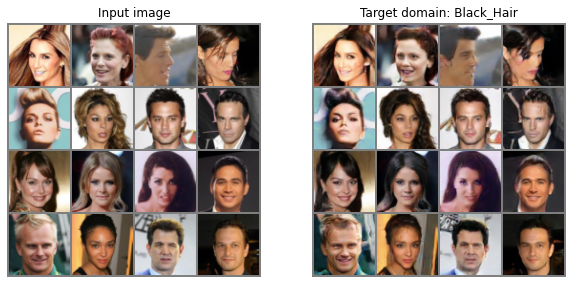

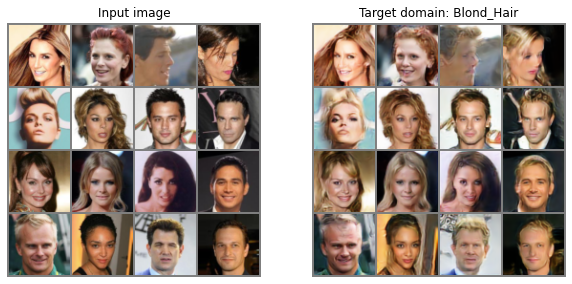

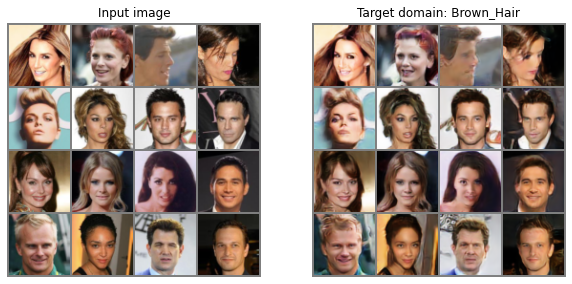

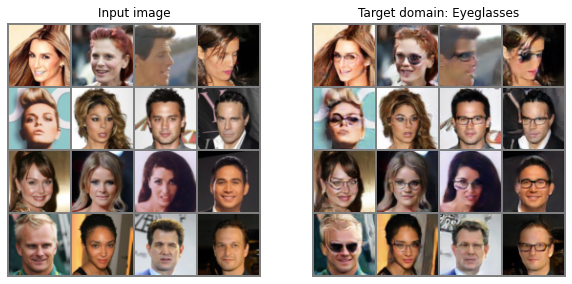

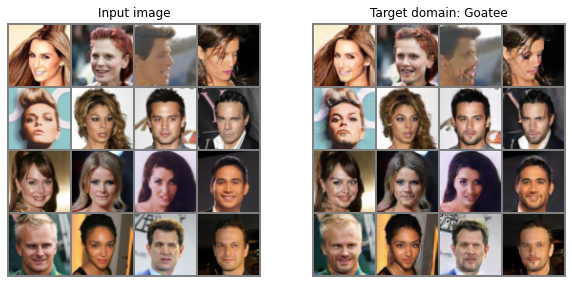

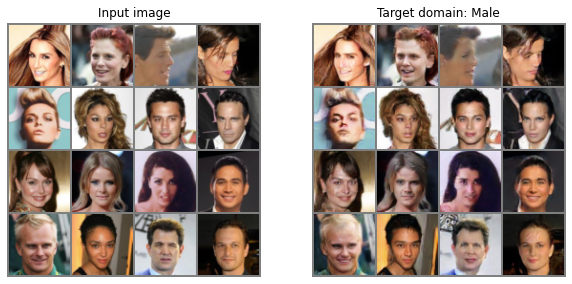

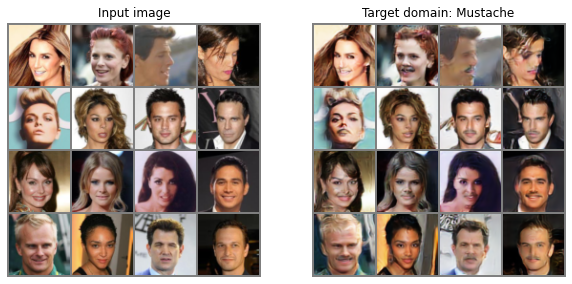

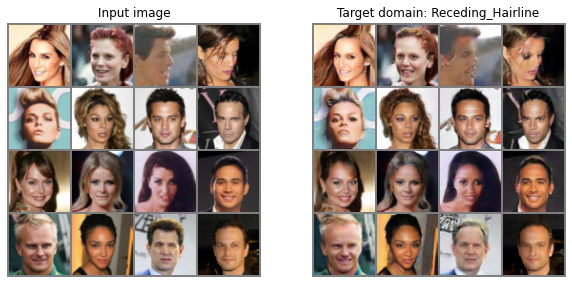

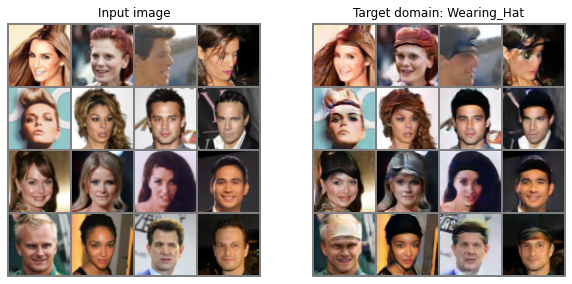

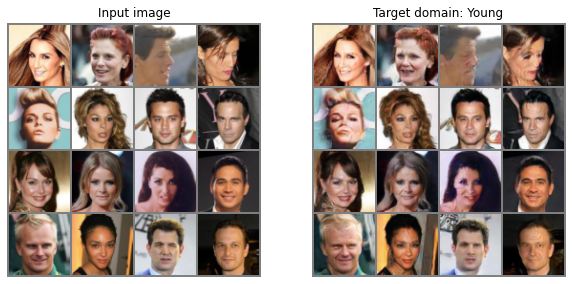

In [18]:
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=16, 
    drop_last=True)
x_real, y_real = next(iter(dataloader))
y_real = y_real.float()
x_real, y_real = x_real.to(device), y_real.to(device)
for label_index in range(10):
    y_trg = y_real.clone()
    y_trg[:, label_index] = 1 - y_trg[:, label_index] # reverse
    with torch.no_grad():
        x_fake = generator(x_real, y_trg)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    x_show = make_grid(x_real, nrow=4, normalize=False).detach().cpu()
    plot_img(x_show, t_invnormalize)
    plt.title(f'Input image')
    plt.subplot(1, 2, 2)
    x_show = make_grid(x_fake, nrow=4, normalize=False).detach().cpu()
    plot_img(x_show, t_invnormalize)
    plt.title(f'Target domain: {attr_name[label_index]}')

Во время обучения вы можете считать FID вашей модели, но для автопроверки мы решили использовать LPIPS — [Learned Perceptual Image Patch Similarity](https://arxiv.org/abs/1801.03924) как финальную метрику качества. 

In [19]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

from lpips_pytorch import LPIPS
lpips = LPIPS().to(device)

    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

Ячейка на 4 балла:

In [20]:
def evaluate_model(dataloader, generator):
    values = []
    for x_real, label in tqdm(dataloader):
        x_real, label = x_real.to(device), label.to(device).float()
        target_domain = label.flip(dims=[0])
        with torch.no_grad():
            x_fake = generator(x_real, target_domain)
        values.append(lpips(x_fake, x_real).squeeze().item())
    return np.mean(values)
    
eval_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=1
)
len(eval_dataloader)

lpips_score = evaluate_model(eval_dataloader, generator)
assert lpips_score < 1

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Ячейка на 3 балла:

In [21]:
assert lpips_score < 0.1

Ячейка на 3 балла:

In [22]:
assert lpips_score < 0.06

In [23]:
round(lpips_score, 4)

0.0367

### Задача 2. Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **1+ балл**
1. Посмотрите получается ли у вас интерполяция в латентном пространстве
2. Покажите на каких доменах ваша модель работает хорошо, на каких не очень.
3. Попробуйте взять внешнюю картинку (не из селебы) и повторить результат.
4. Покажите самый смешной результат мультидоменной перекраски который у вас получался

* Текстовое ревью решения и предложения возможных улучшений - **1+ балл**
1. Опишите как вы решали задачу, какие методы описанные в статье вы использовали. Какие методы из других статей вы пробовали применять, что дало наибольший прирост в качестве?
2. Что бы вы предложили использовать еще, какие возможные улучшения здесь бы еще помогли получить бОльшее качество?


За хороший текст/результаты в этой задаче и за хорошее качество обученных моделей мы можем дать дополнительные баллы которые можно будет прибавить к другим домашкам :)

Эта задача выполняется отдельно и загружается в виде PDF в Anytask

# Результаты:

Лучше всего получается рисовать очки и перекрашивать волосы. А вот со шапками совсем плохо, как и со сменой пола и омоложением.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


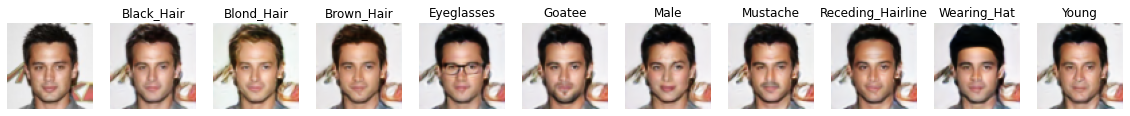

In [31]:
plt.figure(figsize=(20, 20))
x_real, y_real = dataset[6]

plt.subplot(1, 11, 1)
plot_img(x_real, t_invnormalize)

with torch.no_grad():
    x_real, y_real = x_real.to(device).unsqueeze(0), y_real.to(device).unsqueeze(0)
    y_real = y_real.float()

    for label_index in range(10):
        y_trg = y_real.clone()
        y_trg[:, label_index] = 1 - y_trg[:, label_index] # reverse

        with torch.no_grad():
            x_fake = generator(x_real, y_trg)

        plt.subplot(1, 11, label_index+2)
        plot_img(x_fake.squeeze(0).detach().cpu(), t_invnormalize)
        plt.title(attr_name[label_index])
plt.show()    


На этом мужчине почти все получается очень хорошо.

# Решение:

Сначала взяла архитектуру и оптимизацию как в статье. Авторы предлагали учить 10 эпох с лернинг рейтом 1е-4, а потом линейно уменьшать до 0. Потом посмотрела в код, оказалось, что у них эпохи считались по батчу. Оставила политику на лр по обычным эпохам. Для уменьшения веса сетки уменьшила число резблоков. Картинки получались в точку и странных цветов (потом сказали, что для инстанс нормализации не нужно включать eval) -> поменяла инстанс нормализацию на батч нормализацию, также поменялся ConvTranspose2d на Upsample + Conv2d.